## Setup the Env


In [21]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [22]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib

warnings.filterwarnings("ignore")

## Load Data

In [23]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [24]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [25]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [26]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [27]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Feature Engineering

### Feature Selection

In [28]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Add positional_encoding

In [29]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

### Check inf and missing values

In [30]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [31]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
7656926,2023-11-16,93436,-0.038835,0.038835,-0.000869,-0.004937,-0.001334,0.004114,0.324775,0.324775,0.050085,0.050085,0.026224,0.026224,0.355413,0.288883,0.330446
7656927,2023-11-17,93436,0.003035,0.003035,0.002385,0.003949,0.003156,-0.000656,0.235617,0.235617,0.052651,0.052651,0.019067,0.019067,0.371970,0.289036,0.336745
7656928,2023-11-20,93436,0.005533,0.005533,0.009430,0.007483,0.007163,0.006781,0.101719,0.101719,0.022650,0.022650,0.000000,0.000000,0.396123,0.300512,0.000000
7656929,2023-11-21,93436,0.023491,0.023491,-0.002472,-0.003581,-0.003160,-0.001215,-0.049519,0.049519,-0.022278,0.022278,0.000000,0.000000,0.369358,0.286615,0.000000
7656930,2023-11-22,93436,-0.029408,0.029408,-0.001036,0.004794,0.004151,0.004135,0.030445,0.030445,0.027974,0.027974,0.000000,0.000000,0.329192,0.258743,0.000000
7656931,2023-11-24,93436,0.005280,0.005280,-0.000404,0.006189,0.000437,0.001657,0.073508,0.073508,0.085981,0.085981,0.000000,0.000000,0.337080,0.325520,0.000000
7656932,2023-11-27,93436,0.002672,0.002672,-0.001712,-0.003564,-0.002027,-0.003296,0.073767,0.073767,0.095855,0.095855,0.000000,0.000000,0.337084,0.326089,0.000000
7656933,2023-11-28,93436,0.044083,0.044083,-0.000177,-0.008462,0.000747,-0.002023,-0.082184,0.082184,0.028019,0.028019,0.000000,0.000000,0.198041,0.275052,0.000000
7656934,2023-11-29,93436,-0.010512,0.010512,0.002796,0.005689,0.000772,-0.001893,-0.006302,0.006302,0.069404,0.069404,0.000000,0.000000,0.193030,0.279782,0.000000
7656935,2023-11-30,93436,-0.016770,0.016770,-0.000674,0.003475,0.003368,0.004055,-0.007258,0.007258,0.037967,0.037967,0.000000,0.000000,0.193708,0.326211,0.000000


In [32]:
data.describe()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
count,809883,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000
mean,2021-01-02 19:26:16.187671808,0.000347,0.015239,0.000340,0.000143,0.000335,0.000226,0.062016,0.221782,0.011755,0.075367,0.003473,0.026526,0.299785,0.309311,0.315029
min,2018-01-02 00:00:00,-0.773592,0.000000,-1.949859,-0.510336,-0.129686,-0.095060,-0.999627,0.000000,-0.918449,0.000000,-0.505787,0.000000,0.000000,0.000000,0.000000
25%,2019-07-10 00:00:00,-0.009627,0.004608,-0.006371,-0.006763,-0.005049,-0.005496,-0.119866,0.067578,-0.043232,0.024668,-0.014979,0.008843,0.167155,0.186708,0.200940
50%,2021-01-05 00:00:00,0.000817,0.010260,0.000887,0.000677,0.000743,0.000637,0.024535,0.150276,0.010485,0.054429,0.004058,0.019569,0.243410,0.259283,0.269265
75%,2022-07-01 00:00:00,0.010825,0.019626,0.007900,0.008082,0.007133,0.006488,0.181726,0.279142,0.063910,0.100071,0.023282,0.035404,0.359321,0.363738,0.365940
max,2023-12-29 00:00:00,0.629788,0.773592,4.629079,1.409433,0.090241,0.100972,122.448772,122.448772,4.453196,4.453196,0.758288,0.758288,5.258937,4.398254,3.282485
std,NaN,0.023655,0.018095,0.018470,0.015654,0.013260,0.012536,0.483496,0.434081,0.108734,0.079254,0.037834,0.027200,0.228246,0.212317,0.200876


In [33]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [34]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
794341,2023-10-09,93436,-0.003306,0.003306,0.004974,0.006552,0.005551,-0.000367,-0.293906,0.293906,-0.251437,0.251437,-0.033449,0.033449,0.371351,0.504321,0.566852
794342,2023-10-10,93436,0.015097,0.015097,0.005459,0.009881,0.006468,0.008715,-0.604529,0.604529,-0.310775,0.310775,-0.037190,0.037190,0.600659,0.500945,0.564252
794343,2023-10-11,93436,-0.002393,0.002393,0.004413,0.000132,0.003790,0.001008,-0.670007,0.670007,-0.292939,0.292939,-0.034734,0.034734,0.579893,0.521671,0.564991
794344,2023-10-12,93436,-0.015790,0.015790,-0.006896,-0.016643,-0.008780,-0.010085,-0.641309,0.641309,-0.256098,0.256098,-0.022469,0.022469,0.605129,0.552761,0.569565
794345,2023-10-13,93436,-0.030395,0.030395,-0.141350,-0.013752,-0.005451,-0.003587,-0.533462,0.533462,-0.163762,0.163762,-0.022159,0.022159,0.672323,0.636680,0.569121
794346,2023-10-16,93436,0.011088,0.011088,0.008951,0.013014,0.009906,0.011120,-0.600587,0.600587,-0.168558,0.168558,-0.023983,0.023983,0.634819,0.634094,0.568094
794347,2023-10-17,93436,0.003656,0.003656,-0.005996,0.002844,0.001109,0.002598,-0.667258,0.667258,-0.175794,0.175794,-0.024291,0.024291,0.601200,0.631855,0.567999
794348,2023-10-18,93436,-0.048932,0.048932,-0.019949,-0.024705,-0.015139,-0.017764,-0.555317,0.555317,-0.107271,0.107271,0.005321,0.005321,0.623632,0.613775,0.565927
794349,2023-10-19,93436,-0.097616,0.097616,-0.013942,-0.014399,-0.009451,-0.007062,-0.429405,0.429405,0.011698,0.011698,0.033865,0.033865,0.409488,0.450199,0.478414
794350,2023-10-20,93436,-0.037589,0.037589,-0.013804,-0.011470,-0.012873,-0.009276,-0.242604,0.242604,-0.012174,0.012174,0.040807,0.040807,0.418413,0.486228,0.465549


In [35]:
cleaned_data.isnull().sum()

date                              0
permno_id                         0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

## Create Dataset

In [36]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data['positional_encoding'] = self.data.groupby("permno_id").cumcount()
        
        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate([X, permno_id_one_hot[i:i + self.window_size]], axis=1)  # Concatenate one-hot encoded permno_id
                    X = np.concatenate([X, group['positional_encoding'].iloc[i: i + self.window_size].values.reshape(-1, 1)], axis=1)
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [80]:
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Save datasets locally
joblib.dump(train_dataset, '/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_train_dataset.pkl')
joblib.dump(val_dataset, '/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_val_dataset.pkl')

KeyboardInterrupt: 

### Upload the parquet to s3


In [28]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_train_dataset.pkl",
    bucket,
    "CRSP/crsp_2018-2023_S&P500_train_dataset.pkl",
)

In [29]:
reload_path = s3_download("CRSP/crsp_2018-2023_S&P500_train_dataset.pkl")

## Test

#### Build and Train Model

In [31]:
# Load datasets
train_dataset = joblib.load('/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_train_dataset.pkl')
val_dataset = joblib.load('/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_val_dataset.pkl')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Starting Training...
Epoch 1/10, Training Loss: 0.14033509278669953, Validation Loss: 0.09076328647713508
Epoch 2/10, Training Loss: 0.10535764112137258, Validation Loss: 0.0630652189495102
Epoch 3/10, Training Loss: 0.09205040230881423, Validation Loss: 0.05823324188109367
Epoch 4/10, Training Loss: 0.08698587433900684, Validation Loss: 0.05721059303370214
Epoch 5/10, Training Loss: 0.08456413296516985, Validation Loss: 0.05741884162829768
Epoch 6/10, Training Loss: 0.08309767267201096, Validation Loss: 0.0560696694038568
Epoch 7/10, Training Loss: 0.0824554618448019, Validation Loss: 0.057077947583410046
Epoch 8/10, Training Loss: 0.0805946933105588, Validation Loss: 0.05752073432649336
Epoch 9/10, Training Loss: 0.08037338778376579, Validation Loss: 0.056676376310567704
Epoch 10/10, Training Loss: 0.08035408984869719, Validation Loss: 0.05623390627724509
Training Complete


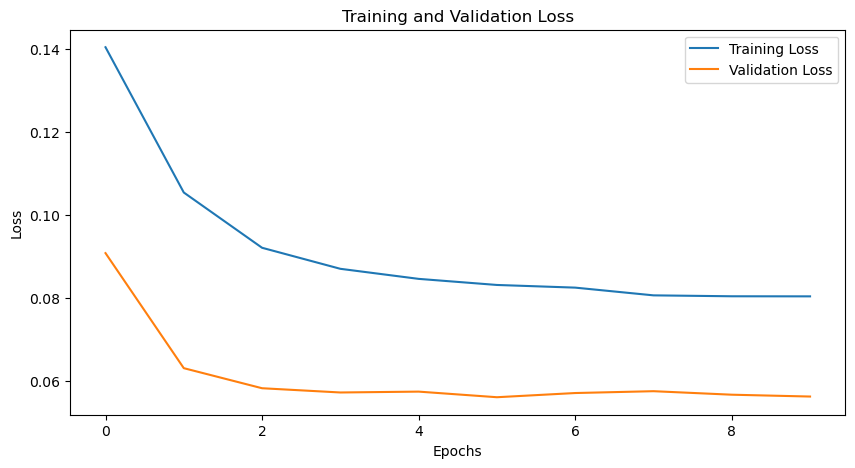

In [32]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding



# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


#### Stock Embedding

In [33]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [34]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [35]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 8.4816766e-01, -1.5194374e+00,  5.9012413e-01, -5.6201398e-01,
          7.6335293e-01, -4.5656464e-01, -5.3003037e-01, -9.2574376e-01,
         -1.2043912e+00,  6.4523458e-01,  3.3464134e-01, -1.7061759e+00,
         -1.2175984e+00,  1.2132494e+00, -2.8131682e-02,  2.1662381e+00,
          3.7906647e-01,  1.0697567e+00,  1.1021727e+00, -7.3253524e-01,
          1.1026136e+00,  8.9342844e-01,  1.4283441e+00, -1.9291799e-01,
         -4.1078594e-01,  1.1794630e+00, -4.8431557e-01, -4.5568582e-01,
          1.1761404e+00, -2.2393908e-01,  1.6652354e+00, -6.9927013e-01,
          3.2872522e-01,  5.7171303e-01, -8.5946906e-01, -1.0537200e+00,
         -1.5642016e+00, -1.5888990e+00, -9.4908351e-01, -1.5516607e+00,
         -4.6480864e-02, -1.4805536e+00,  6.1790133e-01,  4.9487892e-01,
          4.1143429e-01,  1.0928814e+00, -1.6546495e+00,  8.0822176e-01,
          6.0433197e-01,  1.5548137e+00, -4.1606587e-01,  2.2853872e-01,
         -1.0394421e+00, -3.9808327e-01,

#### Cosine Similarity Matrix

In [36]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.]], dtype=float32)

#### Model Features Check

In [37]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [ 5

In [38]:
batch["features"].shape

torch.Size([32, 7, 560])

In [39]:
batch["target"].shape

torch.Size([32, 11])

In [40]:
len(batch["permno_id"])

32

In [41]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [ 5.4969e-03, -2

In [42]:
model(batch["features"].to(device))

(tensor([[-0.0027, -0.0035,  0.0628,  0.1169, -0.0021,  0.0405, -0.0047,  0.0124,
           0.1442,  0.1665,  0.2067],
         [ 0.0007,  0.0028,  0.0522,  0.1206,  0.0056,  0.0433, -0.0041,  0.0168,
           0.1546,  0.1654,  0.2011],
         [ 0.0033,  0.0052,  0.0473,  0.1214,  0.0084,  0.0451, -0.0036,  0.0181,
           0.1588,  0.1657,  0.1994],
         [ 0.0049,  0.0061,  0.0448,  0.1220,  0.0088,  0.0462, -0.0027,  0.0180,
           0.1605,  0.1665,  0.1992],
         [ 0.0060,  0.0066,  0.0432,  0.1225,  0.0090,  0.0472, -0.0020,  0.0179,
           0.1615,  0.1669,  0.1988],
         [ 0.0064,  0.0063,  0.0415,  0.1230,  0.0093,  0.0479, -0.0014,  0.0182,
           0.1622,  0.1675,  0.1980],
         [ 0.0066,  0.0059,  0.0405,  0.1232,  0.0094,  0.0482, -0.0012,  0.0185,
           0.1627,  0.1680,  0.1975],
         [ 0.0066,  0.0057,  0.0395,  0.1235,  0.0095,  0.0484, -0.0012,  0.0190,
           0.1630,  0.1685,  0.1970],
         [ 0.0065,  0.0056,  0.0387,  0.

In [43]:
train_dataset.sequences[-5:]

[(array([[-1.96385808e-02, -2.22870000e-02, -3.19420000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  9.88000000e+02],
         [ 7.90169919e-03,  1.29550000e-02,  7.79200000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  9.89000000e+02],
         [ 1.24027667e-02,  2.23980000e-02,  3.01470000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  9.90000000e+02],
         ...,
         [-1.91282829e-03, -1.32400000e-02, -3.54850000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  9.92000000e+02],
         [ 1.45081680e-01,  1.42930000e-02, -3.86700000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  9.93000000e+02],
         [-1.70993644e-02, -7.50000000e-03, -6.12600000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  9.94000000e+02]]),
  array([-0.00996145,  0.00996145, -0.42433243,  0.42433243, -0.13991876,
          0.13991876, -0.06378652,  0.06378652,  0.55133603,  0.40099837,
          0.31851795]),
  '10104'),
 (array([[ 7.90169919e-03,  1.29

In [44]:
np.array(stock_embeddings["10104"]).shape

(256,)